### 11763 Medical Image Processing 

Amelia Yolanda / May 2024

Objective 1: DICOM loading and visualization
- Download the dataset HCC-TACE-Seg (click here). In the following, consider only the patient HCC XYZ assigned to you (see Aula Digital),
- Visualize it with the help of a third party DICOM visualizer (3D-Slicer is recommended).
- Load the segmentation image, and the corresponding CT image with PyDicom. Rearrange the image and segmentation ‘pixel array’ given by PyDicom based on the headers.
- Create an animation (e.g. gif file) with a rotating Maximum Intensity Projection on the coronal-sagittal planes.

In [58]:
import os
import matplotlib
import numpy as np
import scipy
import pydicom
import pandas as pd
import glob

from matplotlib import pyplot as plt, animation

In [59]:
segmentation_path = "./manifest-1714835132158-initial/HCC-TACE-Seg/HCC_015/11-01-1998-NA-CT ABDPEL WWO LIVER-64482/300.000000-Segmentation-54558/1-1.dcm"
#ct_path = "./manifest-1714835132158/HCC-TACE-Seg/HCC_015/11-01-1998-NA-CT ABDPEL WWO LIVER-64482/4.000000-Recon 2 LIVER 3 PHASE AP-06472/"
ct_path = "./manifest-1714835132158-initial/HCC-TACE-Seg/HCC_015/11-01-1998-NA-CT ABDPEL WWO LIVER-64482/103.000000-LIVER 3 PHASE AP-44492/"


#### Load segmentation dataset

In [60]:
# Load segmentation dataset
segmentation = pydicom.dcmread(segmentation_path)

print("Segmentation pixel_array shape: ", segmentation.pixel_array.shape)

Segmentation pixel_array shape:  (244, 512, 512)


In [61]:
# Check sequence slice (label) in segmentation data
def sequence_slices(segmentation):
    if 'SegmentSequence' in segmentation:
        segments_seq = segmentation.SegmentSequence
        sequence_slices = []
        
        for segment in segments_seq:
            # Append segment information to the list
            sequence_slices.append({
                'SegmentNumber': segment.SegmentNumber,
                'SegmentLabel': segment.SegmentLabel,
            })
        return sequence_slices
    else:
        print("SegmentSequence not found in DICOM file.")
        return []

In [62]:
sequence_slice = sequence_slices(segmentation)
if sequence_slice:
    print("Sequence slices found:")
    for slice_info in sequence_slice:
        print(slice_info)
        

Sequence slices found:
{'SegmentNumber': 1, 'SegmentLabel': 'Liver'}
{'SegmentNumber': 2, 'SegmentLabel': 'Mass'}
{'SegmentNumber': 3, 'SegmentLabel': 'Portal vein'}
{'SegmentNumber': 4, 'SegmentLabel': 'Abdominal aorta'}


In [63]:
# Determine the slice indices for each segment
def determine_slice_indices(segmentation, segments_info):
    segment_indices = {}
    frames = segmentation.PerFrameFunctionalGroupsSequence
    for i, frame in enumerate(frames):
        ref_segment_number = frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber
        if ref_segment_number not in segment_indices:
            segment_indices[ref_segment_number] = []
        segment_indices[ref_segment_number].append(i)
    return segment_indices

# Get slice indices for each segment
segment_indices = determine_slice_indices(segmentation, sequence_slice)
for keys,values in segment_indices.items():
    print("Segment Number: ", keys)
    print("Index: ", values)

Segment Number:  1
Index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Segment Number:  2
Index:  [61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121]
Segment Number:  3
Index:  [122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182]
Segment Number:  4
Index:  [183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199

From the segment indices above, we get to know that the shape of segmentation (244, 512, 512) represent four different parts/labels, e.g. the index 61-121 shows mass/tumor in the segmentation part.

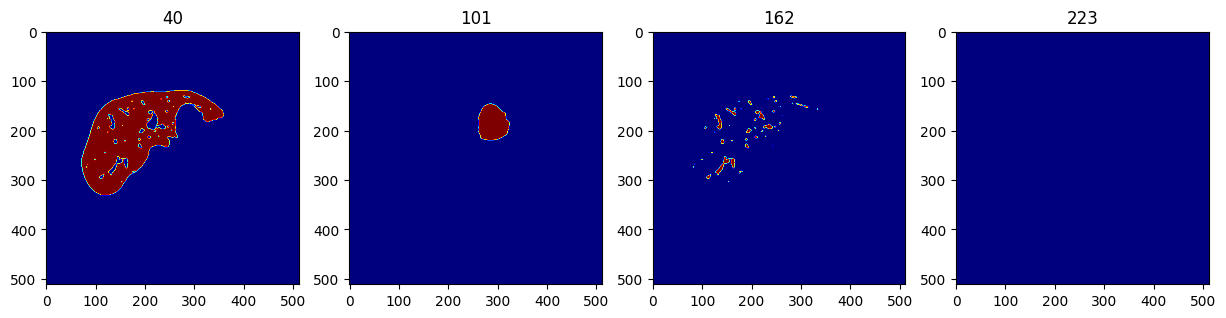

In [117]:
# Sample segmentation pixel_array
fig = plt.figure(figsize=(15, 10))
index = 40
ax1 = fig.add_subplot(141)
ax1.set_title(index)
ax1.imshow(segmentation.pixel_array[index, :, :], cmap='jet')

ax2 = fig.add_subplot(142)
ax2.set_title(index+61)
ax2.imshow(segmentation.pixel_array[index+61, :, :], cmap='jet')

ax3 = fig.add_subplot(143)
ax3.set_title(index+122)
ax3.imshow(segmentation.pixel_array[index+122, :, :], cmap='jet')

ax4 = fig.add_subplot(144)
ax4.set_title(index+183)
ax4.imshow(segmentation.pixel_array[index+183, :, :], cmap='jet')


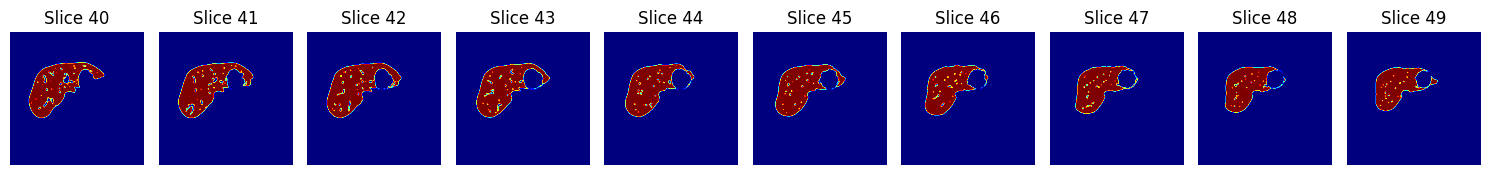

In [118]:
# Sample of segmentation pixel_array
num_images = 10  # Number of images to display
fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

# Loop through the range of indices and display each image
for i in range(num_images):
    idx = i + 40 
    ax = axes[i]
    ax.imshow(segmentation.pixel_array[idx, :, :], cmap='jet')
    ax.set_title(f'Slice {idx}')
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [66]:

# Get metadata information from frames in segmentation data

segmentation_df = pd.DataFrame()
s_img_position = []
s_ref_segment_number = []
s_source_image_uid = []

frames = segmentation.PerFrameFunctionalGroupsSequence

for frame in frames:
    ref_segment_number = frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber
    img_position = tuple(frame.PlanePositionSequence[0].ImagePositionPatient)
    source_image_uid = frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID

    s_ref_segment_number.append(ref_segment_number)
    s_img_position.append(img_position)
    s_source_image_uid.append(source_image_uid)

segmentation_df = pd.DataFrame(data = {
    "ReferencedSegmentNumber": s_ref_segment_number,
    "ImagePositionPatient": s_img_position,
    "SourceImageUID": s_source_image_uid,
})

In [67]:
segmentation_df.head()

,ReferencedSegmentNumber,ImagePositionPatient,SourceImageUID
0,1,"(-1.610000e+02, -1.700000e+02, -2.300000e+02)",1.3.6.1.4.1.14519.5.2.1.1706.8374.139517200870...
1,1,"(-1.610000e+02, -1.700000e+02, -2.275000e+02)",1.3.6.1.4.1.14519.5.2.1.1706.8374.282959315229...
2,1,"(-1.610000e+02, -1.700000e+02, -2.250000e+02)",1.3.6.1.4.1.14519.5.2.1.1706.8374.135980397119...
3,1,"(-1.610000e+02, -1.700000e+02, -2.225000e+02)",1.3.6.1.4.1.14519.5.2.1.1706.8374.166849240807...
4,1,"(-1.610000e+02, -1.700000e+02, -2.200000e+02)",1.3.6.1.4.1.14519.5.2.1.1706.8374.606666744959...


#### Load CT dataset

In [68]:
def extract_ct_data(ct_path_sort):
    ct_data = []
    ct_metadata = []

    for file in ct_path_sort:
        if file.endswith(".dcm"):
            path = os.path.join(ct_path, file)
            dataset = pydicom.dcmread(path)  # Load DICOM file
            #ct_data.append(dataset.pixel_array)
            ct_data.append(dataset)

            # Extract and append DICOM metadata to list
            ct_metadata.append({
                'AcquisitionNumber': dataset.AcquisitionNumber,
                'SliceLocation': dataset.SliceLocation,
                'SliceIndex': dataset.InstanceNumber,
                'SliceThickness': dataset.SliceThickness,
                #'ImagePositionPatient': dataset.ImagePositionPatient,
                'ImagePositionPatient': tuple(dataset.ImagePositionPatient),
                'ReferencedSegmentNumber': dataset.SOPInstanceUID,
                'CTFile': file
            })
    # Convert metadata list to DataFrame
    metadata_df = pd.DataFrame(ct_metadata)
    return ct_data, metadata_df

In [70]:
# Ensure dataset in correct order
ct_path_sort = sorted(os.listdir(ct_path))

In [71]:
ct_data, ct_metadata = extract_ct_data(ct_path_sort)
print("Amount of DICOM file in CT data: ", len(ct_data))

Amount of DICOM file in CT data:  62


In [72]:
ct_metadata.tail()

,AcquisitionNumber,SliceLocation,SliceIndex,SliceThickness,ImagePositionPatient,ReferencedSegmentNumber,CTFile
57,3,-220.529999,58,2.5,"(-161.000000, -170.000000, -220.529999)",1.3.6.1.4.1.14519.5.2.1.1706.8374.606666744959...,1-58.dcm
58,3,-223.029999,59,2.5,"(-161.000000, -170.000000, -223.029999)",1.3.6.1.4.1.14519.5.2.1.1706.8374.166849240807...,1-59.dcm
59,3,-225.529999,60,2.5,"(-161.000000, -170.000000, -225.529999)",1.3.6.1.4.1.14519.5.2.1.1706.8374.135980397119...,1-60.dcm
60,3,-228.029999,61,2.5,"(-161.000000, -170.000000, -228.029999)",1.3.6.1.4.1.14519.5.2.1.1706.8374.282959315229...,1-61.dcm
61,3,-230.529999,62,2.5,"(-161.000000, -170.000000, -230.529999)",1.3.6.1.4.1.14519.5.2.1.1706.8374.139517200870...,1-62.dcm


In [73]:
# Check the content of Acquisition Number
ct_metadata.AcquisitionNumber.unique()

array([3])

#### Match CT and segmentation data

In [74]:
print(f"CT data shape: {ct_data[0].pixel_array.shape}")
print(f"Segmentation data shape: {segmentation.pixel_array.shape}")

CT data shape: (512, 512)
Segmentation data shape: (244, 512, 512)


In [75]:
# Merge CT and segmentation metadata on the corresponding key
merge_metadata = pd.merge(ct_metadata, segmentation_df, 
                             left_on='ReferencedSegmentNumber', right_on='SourceImageUID', 
                             suffixes=('_CT', '_Seg'))

print("Combined Metadata:")
merge_metadata.head()

Combined Metadata:


,AcquisitionNumber,SliceLocation,SliceIndex,SliceThickness,ImagePositionPatient_CT,ReferencedSegmentNumber_CT,CTFile,ReferencedSegmentNumber_Seg,ImagePositionPatient_Seg,SourceImageUID
0,3,-80.529999,2,2.5,"(-161.000000, -170.000000, -80.529999)",1.3.6.1.4.1.14519.5.2.1.1706.8374.281560891745...,1-02.dcm,1,"(-1.610000e+02, -1.700000e+02, -8.000000e+01)",1.3.6.1.4.1.14519.5.2.1.1706.8374.281560891745...
1,3,-80.529999,2,2.5,"(-161.000000, -170.000000, -80.529999)",1.3.6.1.4.1.14519.5.2.1.1706.8374.281560891745...,1-02.dcm,2,"(-1.610000e+02, -1.700000e+02, -8.000000e+01)",1.3.6.1.4.1.14519.5.2.1.1706.8374.281560891745...
2,3,-80.529999,2,2.5,"(-161.000000, -170.000000, -80.529999)",1.3.6.1.4.1.14519.5.2.1.1706.8374.281560891745...,1-02.dcm,3,"(-1.610000e+02, -1.700000e+02, -8.000000e+01)",1.3.6.1.4.1.14519.5.2.1.1706.8374.281560891745...
3,3,-80.529999,2,2.5,"(-161.000000, -170.000000, -80.529999)",1.3.6.1.4.1.14519.5.2.1.1706.8374.281560891745...,1-02.dcm,4,"(-1.610000e+02, -1.700000e+02, -8.000000e+01)",1.3.6.1.4.1.14519.5.2.1.1706.8374.281560891745...
4,3,-83.029999,3,2.5,"(-161.000000, -170.000000, -83.029999)",1.3.6.1.4.1.14519.5.2.1.1706.8374.132759015755...,1-03.dcm,1,"(-1.610000e+02, -1.700000e+02, -8.250000e+01)",1.3.6.1.4.1.14519.5.2.1.1706.8374.132759015755...


In [76]:
merge_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   AcquisitionNumber            244 non-null    int64  
 1   SliceLocation                244 non-null    float64
 2   SliceIndex                   244 non-null    int64  
 3   SliceThickness               244 non-null    float64
 4   ImagePositionPatient_CT      244 non-null    object 
 5   ReferencedSegmentNumber_CT   244 non-null    object 
 6   CTFile                       244 non-null    object 
 7   ReferencedSegmentNumber_Seg  244 non-null    int64  
 8   ImagePositionPatient_Seg     244 non-null    object 
 9   SourceImageUID               244 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 19.2+ KB


In [77]:
# Taking CT data with SliceLocation
merge_data = {}

for file in ct_data:
    merge_data[float(file.SliceLocation)] = file.pixel_array

In [78]:
merge_data # len = 62

{-78.029999: array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16),
 -80.529999: array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16),
 -83.029999: array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024

In [79]:
sorted_merge_data = {key:merge_data[key] for key in sorted(merge_data.keys())}

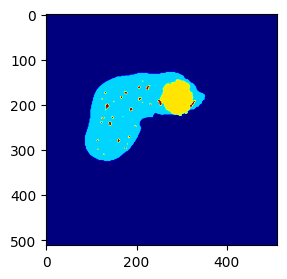

In [80]:
# Combine all labels in the segmentation file into one
idx = 45
weights = [0.2, 0.4, 0.6, 0.9]

# Extract the pixel arrays for the regions and apply weights
region1 = segmentation.pixel_array[idx, :, :] * weights[0]
region2 = segmentation.pixel_array[idx + 61, :, :] * weights[1]
region3 = segmentation.pixel_array[idx + 2 * 61, :, :] * weights[2]
region4 = segmentation.pixel_array[idx + 3 * 61, :, :] * weights[3]

# Combine the regions
all_regions = region1 + region2 + region3 + region4

# Display the combined segmentation
plt.figure(figsize=(3, 3))
plt.imshow(all_regions, cmap='jet')
# plt.title(f'Combined Segmentation for Slice {idx}')

In [81]:
len(sorted_merge_data)

62

In [86]:
# from activity02
def apply_cmap(img: np.ndarray, cmap_name: str = 'bone') -> np.ndarray:
    """ Apply a colormap to a 2D image. """
    cmap_function = matplotlib.colormaps[cmap_name]
    return cmap_function(img)

def visualize_alpha_fusion(img: np.ndarray, mask: np.ndarray, alpha: float = 0.25):
    """ Visualize both image and mask in the same plot. """
    img_sagittal_cmapped = apply_cmap(img, cmap_name='bone')    # Why 'bone'?
    mask_bone_cmapped = apply_cmap(mask, cmap_name='prism')     # Why 'prism'?
    mask_bone_cmapped = mask_bone_cmapped * mask[..., np.newaxis].astype('bool')

    alpha = 0.5
    fused_slice = img_sagittal_cmapped * (1-alpha) + mask_bone_cmapped * alpha
    #plt.imshow(img_sagittal_cmapped * (1-alpha) + mask_bone_cmapped * alpha, aspect=0.98/3.27)
    #plt.title(f'Segmentation with alpha {alpha}')
    #plt.show()
    
    return fused_slice

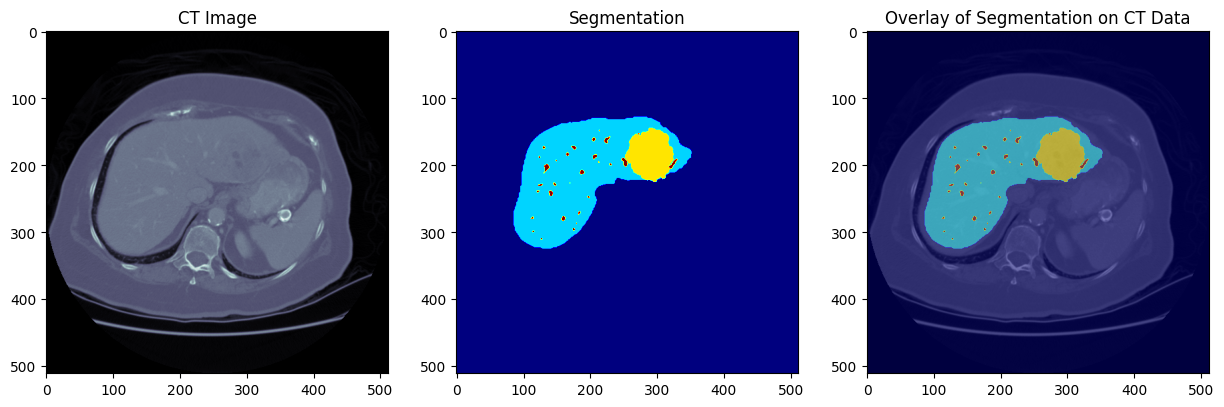

In [87]:
# Overlay segmentation on CT images
def overlay_segmentation_on_ct(ct_image, segmentation_image, alpha=0.5):
    fig = plt.figure(figsize=(15, 8))
    
    # Plot CT image
    ax1 = fig.add_subplot(131)
    ax1.set_title('CT Image')
    ax1.imshow(ct_image, cmap='bone')

    # Plot Segmentation
    ax2 = fig.add_subplot(132)
    ax2.set_title('Segmentation')
    ax2.imshow(segmentation_image, cmap='jet')

    # Overlay Segmentation on CT image
    ax3 = fig.add_subplot(133)
    ax3.set_title('Overlay of Segmentation on CT Data')
    ax3.imshow(ct_image, cmap='gist_gray')
    ax3.imshow(segmentation_image, cmap='jet', alpha=alpha)

    # Extract the combined slice
    fused_img = visualize_alpha_fusion(ct_image, segmentation_image)
    return fused_img

key = list(sorted_merge_data.keys())[idx] # Retrieve the key in dict, which is SliceLocation
ct_selected = sorted_merge_data[key] # Take the specific CT data as similar to index

combined_pixel = overlay_segmentation_on_ct(ct_selected, all_regions)
#plt.show()

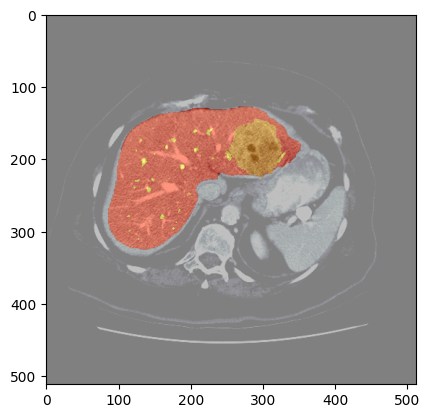

In [88]:
plt.imshow(combined_pixel)

In [96]:
# Define the weights
weights = [0.2, 0.4, 0.6, 0.9]

# Initialize an empty list to store the combined segmentations
combined_img_seg = []

# Loop through length of CT data 
for idx in range(len(sorted_merge_data)):
    key = list(sorted_merge_data.keys())[idx] 
    ct_selected = sorted_merge_data[key] 

    # Extract the pixel arrays for the regions and apply weights
    region1 = segmentation.pixel_array[idx, :, :] * weights[0]
    region2 = segmentation.pixel_array[idx + 61, :, :] * weights[1]
    region3 = segmentation.pixel_array[idx + 2 * 61, :, :] * weights[2]
    if idx < 61:
        region4 = segmentation.pixel_array[idx + 3 * 61, :, :] * weights[3]
    else:
        region4 = segmentation.pixel_array[243, :, :] * weights[3]

    # Combine the regions
    all_regions = region1 + region2 + region3 + region4

    # Append the combined CT and segmentation to the list
    fused_img = visualize_alpha_fusion(ct_selected, all_regions)
    combined_img_seg.append(fused_img)

# Convert the list to a NumPy array for easier manipulation
combined_image_array = np.array(combined_img_seg)

print(len(combined_image_array))

62


In [97]:
img_dcm = combined_image_array


In [98]:
img_dcm.shape

(62, 512, 512, 4)

In [104]:
# from activity03

def median_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, :, img_dcm.shape[1]//2]    # Why //2?
    #the floor division // rounds the result down to the nearest whole number

def median_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, img_dcm.shape[2]//2, :]

def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    # Your code here:
    #   See `np.max(...)`
    # ...
    return np.max(img_dcm, axis=2)

def AIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the sagittal orientation. """
    # Your code here:
    #   See `np.mean(...)`
    # ...
    return np.mean(img_dcm, axis=2)


def MIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation. """
    # Your code here:
    # ...
    return np.max(img_dcm, axis=1)


def AIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the coronal orientation. """
    # Your code here:
    # ...
    return np.mean(img_dcm, axis=1)


def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    # Your code here:
    #   See `scipy.ndimage.rotate(...)`
    # ...
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1,2), reshape=False)



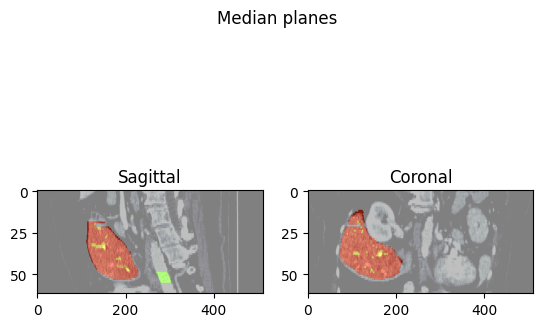

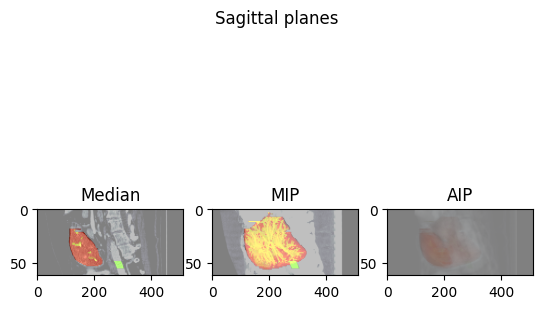

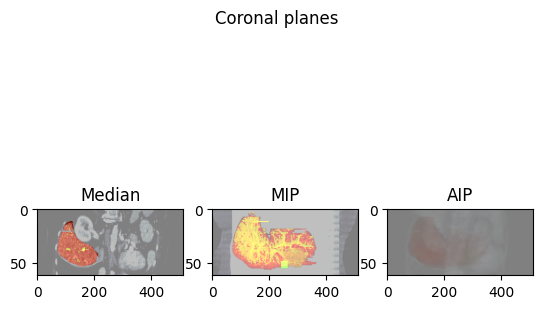

In [105]:
#pixel_len_mm = [2.5, 0.664062, 0.664062]
pixel_len_mm = [ct_data[0].SliceThickness, ct_data[0].PixelSpacing[0], ct_data[0].PixelSpacing[1]]  # Pixel length in mm [z, y, x]

# Show median planes
fig, ax = plt.subplots(1, 2)
ax[0].imshow(median_sagittal_plane(img_dcm), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0].set_title('Sagittal')
ax[1].imshow(median_coronal_plane(img_dcm), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[2])
ax[1].set_title('Coronal')
fig.suptitle('Median planes')
plt.show()

# Show MIP/AIP/Median Sagittal planes
fig, ax = plt.subplots(1, 3)
ax[0].imshow(median_sagittal_plane(img_dcm), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0].set_title('Median')
ax[1].imshow(MIP_sagittal_plane(img_dcm), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1].set_title('MIP')
ax[2].imshow(AIP_sagittal_plane(img_dcm), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[2].set_title('AIP')
fig.suptitle('Sagittal planes')
plt.show()
   
# Show MIP/AIP/Median Coronal planes
fig, ax = plt.subplots(1, 3)
ax[0].imshow(median_coronal_plane(img_dcm), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0].set_title('Median')
ax[1].imshow(MIP_coronal_plane(img_dcm), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1].set_title('MIP')
ax[2].imshow(AIP_coronal_plane(img_dcm),cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[2].set_title('AIP')
fig.suptitle('Coronal planes')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [7.247534778892689e-68..1.0000000000000009].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.39615048142643e-53..1.137166373764634].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.0264891093102864e-53..1.136215862327825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.451409931521193e-53..1.1324813188117278].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.685391857472195e-53..1.1354621784894698].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.5901860954824022e-54..1.1287671409490263].
Clipping in

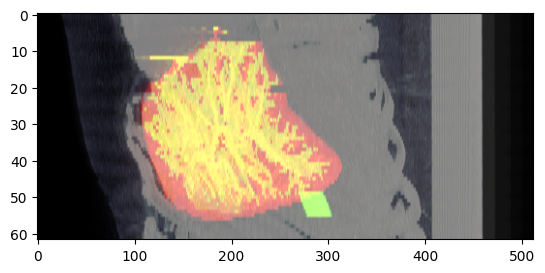

In [108]:
pixel_len_mm = [2.5, 0.664062, 0.664062]

# Create projections varying the angle of rotation
# Configure visualization colormap
img_min = np.amin(img_dcm)
img_max = np.amax(img_dcm)
#cm = matplotlib.cm.get_cmap('bone')
cm = matplotlib.colormaps["bone"]
fig, ax = plt.subplots()

#   Configure directory to save results
#os.makedirs('./', exist_ok=True)

#   Create projections
n = 48
projections = []
projections_segments = []

for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(img_dcm, alpha)
    projection = MIP_sagittal_plane(rotated_img)
    
    plt.imshow(projection, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])
    plt.savefig(f'./Projection_{idx}.png')      # Save animation
    projections.append(projection)  # Save for later animation

# Save and visualize animation
animation_data = [
    [plt.imshow(img, animated=True, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])]
    for img in projections
]
anim = animation.ArtistAnimation(fig, animation_data,
                          interval=250, blit=True)
anim.save('./Animation1.gif')  # Save animation
plt.show()
